In [1]:
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Gradient Boosting
import lightgbm as lgb

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 
from string import punctuation

# Viz
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print("\nData Load Stage")
training = pd.read_csv('train.csv',parse_dates = ["activation_date"])
traindex = training.index

testing = pd.read_csv('test.csv',parse_dates = ["activation_date"])
testdex = testing.index
test_item = testing['item_id']

y = training['deal_probability'].copy()
training.drop("deal_probability",axis=1, inplace=True)

print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))


Data Load Stage
Train shape: 1503424 Rows, 17 Columns
Test shape: 508438 Rows, 17 Columns


In [3]:
training.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0


In [4]:
testing.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
0,6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,На ангарском,NaN,66,2017-04-18,Private,a8b57acb5ab304f9c331ac7a074219aed4d349d8aef386...,2020.0
1,65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,"Продам велосипед KAMA F200,в нормальном состо...",3000.0,4,2017-04-16,Private,NaN,NaN
2,8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,Продам новый телевизор BBK 32 диагональ смарт...,15000.0,15,2017-04-17,Private,8c361112cb049745ef2d1b0ae73594fc5c107286b0c942...,2960.0
3,8e348601fefc,5f1d5c3ce0da,Саратовская область,Саратов,Для дома и дачи,Бытовая техника,Для кухни,Вытяжки,NaN,Вытяжка Jetair 60,"Продам новую вытяжку в упаковке,с документами....",4500.0,70,2017-04-17,Private,NaN,NaN
4,8bd2fe400b89,23e2d97bfc7f,Оренбургская область,Бузулук,Личные вещи,Товары для детей и игрушки,Детские коляски,NaN,NaN,Коляска зима-лето,Продам отличную коляску. б/у 1 год. все вопрос...,4900.0,15,2017-04-15,Private,bc3cf6deef10840fc302e38eb48fa7748aa1e28d534f8f...,1002.0


In [5]:
print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

print("Feature Engineering")
df["price"] = np.log(df["price"]+0.001)               # filling in NaN's
df["price"].fillna(-999,inplace=True)
df["image_top_1"].fillna(-999,inplace=True)

print("\nCreate Time Variables")
df["Weekday"] = df['activation_date'].dt.weekday
df["Weekd of Year"] = df['activation_date'].dt.week
df["Day of Month"] = df['activation_date'].dt.day

Combine Train and Test

All Data shape: 2011862 Rows, 17 Columns
Feature Engineering

Create Time Variables


In [6]:
russian_stop = set(stopwords.words('russian'))

In [7]:
df['desc_punctuation_cnt'] = df['description'].apply(lambda x: len("".join(_ for _ in str(x) if _ in punctuation))) 
df['desc_upper_case_word_cnt'] = df['description'].apply(lambda x: len([wrd for wrd in str(x).split() if wrd.isupper()]))
df['stopword_count'] = df['description'].apply(lambda x: len([wrd for wrd in str(x).split() if wrd.lower() in russian_stop]))

### Task 1: Maybe don't fill in NaN's above.

In [8]:
df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,activation_date,user_type,image,image_top_1,Weekday,Weekd of Year,Day of Month,desc_punctuation_cnt,desc_upper_case_word_cnt,stopword_count
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,1,13,28,2,0,1
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,...,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,6,12,26,3,1,3
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0,12,20,5,2,4
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,...,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,5,12,25,1,0,0
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,3,11,16,1,0,2


In [9]:
# Create Validation Index and Remove Dead Variables
training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index

df.drop(["activation_date","image"],axis=1,inplace=True)

print("\nEncode Variables")
categorical = ["region","city","parent_category_name","category_name","user_type","image_top_1"]
print("Encoding :",categorical)

# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col] = lbl.fit_transform(df[col].astype(str))


Encode Variables
Encoding : ['region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1']


In [10]:
# Feature Engineering 
df['text_feat'] = df.apply(lambda row: ' '.join([
    str(row['param_1']), 
    str(row['param_2']), 
    str(row['param_3'])]),axis=1) # Group Param Features into a single string

df.drop(["param_1","param_2","param_3"],axis=1,inplace=True)

In [11]:
df.head()

,item_id,user_id,region,city,parent_category_name,category_name,title,description,price,item_seq_number,user_type,image_top_1,Weekday,Weekd of Year,Day of Month,desc_punctuation_cnt,desc_upper_case_word_cnt,stopword_count,text_feat
0,b912c3c6a6ad,e00f8ff2eaf9,19,462,4,42,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",5.991467,2,1,13,1,13,28,2,0,1,Постельные принадлежности nan nan
1,2dac0150717d,39aeb48f0017,17,1314,2,22,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",8.006368,19,1,2723,6,12,26,3,1,3,Другое nan nan
2,ba83aefab5dc,91e2f88dd6e3,16,1290,0,2,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",8.294050,9,1,2260,0,12,20,5,2,4,"Видео, DVD и Blu-ray плееры nan nan"
3,02996f1dd2ea,bf5cccea572d,21,950,4,42,Автокресло,Продам кресло от0-25кг,7.696213,286,0,2838,5,12,25,1,0,0,Автомобильные кресла nan nan
4,7c90be56d2ab,ef50846afc0b,4,318,6,0,"ВАЗ 2110, 2003",Все вопросы по телефону.,10.596635,3,1,1408,3,11,16,1,0,2,С пробегом ВАЗ (LADA) 2110


In [12]:
# Meta Text Features
textfeats = ["description","text_feat", "title"]

for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('nicapotato') # WHY FILL NANS WITH NICAPOTATO?
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    
    df[cols + '_num_chars'] = df[cols].apply(len) # Count number of Characters
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words

### Adding aggregated features:

In [13]:
df.head()

,item_id,user_id,region,city,parent_category_name,category_name,title,description,price,item_seq_number,...,description_num_unique_words,description_words_vs_unique,text_feat_num_chars,text_feat_num_words,text_feat_num_unique_words,text_feat_words_vs_unique,title_num_chars,title_num_words,title_num_unique_words,title_words_vs_unique
0,b912c3c6a6ad,e00f8ff2eaf9,19,462,4,42,кокоби(кокон для сна),"кокон для сна малыша,пользовались меньше месяц...",5.991467,2,...,7,100.0,33,4,3,75.000000,21,3,3,100.0
1,2dac0150717d,39aeb48f0017,17,1314,2,22,стойка для одежды,"стойка для одежды, под вешалки. с бутика.",8.006368,19,...,7,100.0,14,3,2,66.666667,17,3,3,100.0
2,ba83aefab5dc,91e2f88dd6e3,16,1290,0,2,philips bluray,"в хорошем состоянии, домашний кинотеатр с blu ...",8.294050,9,...,17,100.0,35,7,6,85.714286,14,2,2,100.0
3,02996f1dd2ea,bf5cccea572d,21,950,4,42,автокресло,продам кресло от0-25кг,7.696213,286,...,3,100.0,28,4,3,75.000000,10,1,1,100.0
4,7c90be56d2ab,ef50846afc0b,4,318,6,0,"ваз 2110, 2003",все вопросы по телефону.,10.596635,3,...,4,100.0,26,5,5,100.000000,14,3,3,100.0


In [14]:
ext_feats = pd.read_csv("aggregated_features.csv")
agg_cols = ['avg_days_up_user','avg_times_up_user','n_user_items']

In [15]:
df.head()

,item_id,user_id,region,city,parent_category_name,category_name,title,description,price,item_seq_number,...,description_num_unique_words,description_words_vs_unique,text_feat_num_chars,text_feat_num_words,text_feat_num_unique_words,text_feat_words_vs_unique,title_num_chars,title_num_words,title_num_unique_words,title_words_vs_unique
0,b912c3c6a6ad,e00f8ff2eaf9,19,462,4,42,кокоби(кокон для сна),"кокон для сна малыша,пользовались меньше месяц...",5.991467,2,...,7,100.0,33,4,3,75.000000,21,3,3,100.0
1,2dac0150717d,39aeb48f0017,17,1314,2,22,стойка для одежды,"стойка для одежды, под вешалки. с бутика.",8.006368,19,...,7,100.0,14,3,2,66.666667,17,3,3,100.0
2,ba83aefab5dc,91e2f88dd6e3,16,1290,0,2,philips bluray,"в хорошем состоянии, домашний кинотеатр с blu ...",8.294050,9,...,17,100.0,35,7,6,85.714286,14,2,2,100.0
3,02996f1dd2ea,bf5cccea572d,21,950,4,42,автокресло,продам кресло от0-25кг,7.696213,286,...,3,100.0,28,4,3,75.000000,10,1,1,100.0
4,7c90be56d2ab,ef50846afc0b,4,318,6,0,"ваз 2110, 2003",все вопросы по телефону.,10.596635,3,...,4,100.0,26,5,5,100.000000,14,3,3,100.0


In [16]:
df = df.merge(ext_feats, on='user_id', how='left')

In [17]:
ext_feats.head()

,user_id,avg_days_up_user,avg_times_up_user,n_user_items
0,00000077ff21,12.5,2.00,2
1,000006497719,19.0,2.00,1
2,00000b4d72f6,3.0,1.00,1
3,00000d642d7e,13.0,1.00,2
4,0000126b80a4,12.0,1.75,8


In [18]:
df.head()

,item_id,user_id,region,city,parent_category_name,category_name,title,description,price,item_seq_number,...,text_feat_num_words,text_feat_num_unique_words,text_feat_words_vs_unique,title_num_chars,title_num_words,title_num_unique_words,title_words_vs_unique,avg_days_up_user,avg_times_up_user,n_user_items
0,b912c3c6a6ad,e00f8ff2eaf9,19,462,4,42,кокоби(кокон для сна),"кокон для сна малыша,пользовались меньше месяц...",5.991467,2,...,4,3,75.000000,21,3,3,100.0,8.000000,2.000000,2
1,2dac0150717d,39aeb48f0017,17,1314,2,22,стойка для одежды,"стойка для одежды, под вешалки. с бутика.",8.006368,19,...,3,2,66.666667,17,3,3,100.0,NaN,NaN,1
2,ba83aefab5dc,91e2f88dd6e3,16,1290,0,2,philips bluray,"в хорошем состоянии, домашний кинотеатр с blu ...",8.294050,9,...,7,6,85.714286,14,2,2,100.0,4.428571,1.142857,9
3,02996f1dd2ea,bf5cccea572d,21,950,4,42,автокресло,продам кресло от0-25кг,7.696213,286,...,4,3,75.000000,10,1,1,100.0,16.714286,2.642857,32
4,7c90be56d2ab,ef50846afc0b,4,318,6,0,"ваз 2110, 2003",все вопросы по телефону.,10.596635,3,...,5,5,100.000000,14,3,3,100.0,NaN,NaN,1


In [19]:
df[agg_cols].isna().any(axis=1).sum() / len(df) * 100

22.899234639353992

In [20]:
with pd.option_context('display.max_rows',200, 'display.max_columns', 200):
    display(df.head(40))

,item_id,user_id,region,city,parent_category_name,category_name,title,description,price,item_seq_number,user_type,image_top_1,Weekday,Weekd of Year,Day of Month,desc_punctuation_cnt,desc_upper_case_word_cnt,stopword_count,text_feat,description_num_chars,description_num_words,description_num_unique_words,description_words_vs_unique,text_feat_num_chars,text_feat_num_words,text_feat_num_unique_words,text_feat_words_vs_unique,title_num_chars,title_num_words,title_num_unique_words,title_words_vs_unique,avg_days_up_user,avg_times_up_user,n_user_items
0,b912c3c6a6ad,e00f8ff2eaf9,19,462,4,42,кокоби(кокон для сна),"кокон для сна малыша,пользовались меньше месяц...",5.991467,2,1,13,1,13,28,2,0,1,постельные принадлежности nan nan,58,7,7,100.000000,33,4,3,75.000000,21,3,3,100.0,8.000000,2.000000,2
1,2dac0150717d,39aeb48f0017,17,1314,2,22,стойка для одежды,"стойка для одежды, под вешалки. с бутика.",8.006368,19,1,2723,6,12,26,3,1,3,другое nan nan,41,7,7,100.000000,14,3,2,66.666667,17,3,3,100.0,NaN,NaN,1
2,ba83aefab5dc,91e2f88dd6e3,16,1290,0,2,philips bluray,"в хорошем состоянии, домашний кинотеатр с blu ...",8.294050,9,1,2260,0,12,20,5,2,4,"видео, dvd и blu-ray плееры nan nan",99,17,17,100.000000,35,7,6,85.714286,14,2,2,100.0,4.428571,1.142857,9
3,02996f1dd2ea,bf5cccea572d,21,950,4,42,автокресло,продам кресло от0-25кг,7.696213,286,0,2838,5,12,25,1,0,0,автомобильные кресла nan nan,22,3,3,100.000000,28,4,3,75.000000,10,1,1,100.0,16.714286,2.642857,32
4,7c90be56d2ab,ef50846afc0b,4,318,6,0,"ваз 2110, 2003",все вопросы по телефону.,10.596635,3,1,1408,3,11,16,1,0,2,с пробегом ваз (lada) 2110,24,4,4,100.000000,26,5,5,100.000000,14,3,3,100.0,NaN,NaN,1
5,51e0962387f7,bbfad0b1ad0a,21,1675,4,42,авто люлька,в хорошем состоянии,7.170120,9,1,2838,1,13,28,0,1,1,автомобильные кресла nan nan,19,3,3,100.000000,28,4,3,75.000000,11,2,2,100.0,4.000000,1.000000,2
6,c4f260a2b48a,08f469d2e6f7,11,985,2,38,водонагреватель 100 литров нержавейка плоский,электро водонагреватель накопительный на 100 л...,9.305651,125,1,2027,3,12,23,7,2,3,сантехника и сауна nan nan,141,21,19,90.476190,26,5,4,80.000000,45,5,5,100.0,7.333333,1.222222,11
7,6b71309d6a8a,fef86baa002c,15,1164,4,29,бойфренды colins,бойфренды в хорошем состоянии.,6.214610,61,1,2584,5,12,25,1,0,1,женская одежда джинсы 26,30,4,4,100.000000,24,4,4,100.000000,16,2,2,100.0,11.916667,1.666667,23
8,c5b969cb63a2,055825270190,14,1118,4,29,платье,54 раз мер очень удобное,6.214610,85,1,2416,4,11,17,0,0,1,женская одежда платья и юбки > 50 (xxl),24,5,5,100.000000,39,8,8,100.000000,6,1,1,100.0,13.517241,1.896552,38
9,b1570962e68c,f9e8f831d94c,11,985,4,10,полу ботиночки замш натур.бамбини,по стельке 15.5см мерить приокский район. цвет...,5.991467,136,0,2465,2,12,22,2,0,3,для девочек обувь 25,65,11,11,100.000000,20,4,4,100.000000,33,4,4,100.0,15.632184,2.045977,93


In [21]:
tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}

v1 = TfidfVectorizer(ngram_range=(1, 2),max_features=16000,**tfidf_para)
desc = v1.fit_transform(df['description'])

v2 = TfidfVectorizer(ngram_range=(1, 2),**tfidf_para)
title = v2.fit_transform(df['title'])

cv1 = CountVectorizer(ngram_range=(1, 2))
text_feat = cv1.fit_transform(df['text_feat'])

In [22]:
def get_col(col_name): return lambda x: x[col_name]

vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=16000,
            **tfidf_para,
            preprocessor=get_col('description'))),
        ('text_feat',CountVectorizer(
            ngram_range=(1, 2),
            #max_features=7000,
            preprocessor=get_col('text_feat'))),
        ('title',TfidfVectorizer(
            ngram_range=(1, 2),
            **tfidf_para,
            #max_features=7000,
            preprocessor=get_col('title')))
    ])

In [23]:
start_vect=time.time()
vectorizer.fit(df.loc[traindex,:].to_dict('records'))

ready_df = vectorizer.transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

Vectorization Runtime: 6.12 Minutes


df['description'] = list(desc)
df['title'] = list(title)
df['text_feat'] = list(text_feat)

In [24]:
df.drop(['item_id','description','title','text_feat'],axis=1,inplace=True)

In [25]:
with pd.option_context('display.max_rows',200, 'display.max_columns', 200):
    display(df.head())

,user_id,region,city,parent_category_name,category_name,price,item_seq_number,user_type,image_top_1,Weekday,Weekd of Year,Day of Month,desc_punctuation_cnt,desc_upper_case_word_cnt,stopword_count,description_num_chars,description_num_words,description_num_unique_words,description_words_vs_unique,text_feat_num_chars,text_feat_num_words,text_feat_num_unique_words,text_feat_words_vs_unique,title_num_chars,title_num_words,title_num_unique_words,title_words_vs_unique,avg_days_up_user,avg_times_up_user,n_user_items
0,e00f8ff2eaf9,19,462,4,42,5.991467,2,1,13,1,13,28,2,0,1,58,7,7,100.0,33,4,3,75.000000,21,3,3,100.0,8.000000,2.000000,2
1,39aeb48f0017,17,1314,2,22,8.006368,19,1,2723,6,12,26,3,1,3,41,7,7,100.0,14,3,2,66.666667,17,3,3,100.0,NaN,NaN,1
2,91e2f88dd6e3,16,1290,0,2,8.294050,9,1,2260,0,12,20,5,2,4,99,17,17,100.0,35,7,6,85.714286,14,2,2,100.0,4.428571,1.142857,9
3,bf5cccea572d,21,950,4,42,7.696213,286,0,2838,5,12,25,1,0,0,22,3,3,100.0,28,4,3,75.000000,10,1,1,100.0,16.714286,2.642857,32
4,ef50846afc0b,4,318,6,0,10.596635,3,1,1408,3,11,16,1,0,2,24,4,4,100.0,26,5,5,100.000000,14,3,3,100.0,NaN,NaN,1


X = df.loc[traindex,:].values

testing = df.loc[testdex,:].values

del df 
gc.collect()

In [26]:
df.drop('user_id',axis=1,inplace=True)

In [27]:
print("Modeling Stage")
#Combine Dense Features with Sparse Text Bag of Words Features
X = hstack([csr_matrix(df.loc[traindex,:].values),ready_df[:traindex.shape[0]]]) # Sparse Matrix

testing = hstack([csr_matrix(df.loc[testdex,:].values),ready_df[traindex.shape[0]:]])

tfvocab = df.columns.tolist() + tfvocab

for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
    
print("Feature Names Length: ",len(tfvocab))
del df
gc.collect();

Modeling Stage
1503424 Rows and 1186571 Cols
508438 Rows and 1186571 Cols
Feature Names Length:  1186571


In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.10, random_state=23)
    
print("Light Gradient Boosting Regressor")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 15,
    'num_leaves': 37,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    'learning_rate': 0.019,
    'verbose': 0
} 

Light Gradient Boosting Regressor


In [29]:
lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=tfvocab,
                categorical_feature = categorical)
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=tfvocab,
                categorical_feature = categorical)

In [30]:
modelstart = time.time()

lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=16000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=200,
    verbose_eval=200
)

print("Model training took " + str(time.time() - modelstart))

D:\Anaconda\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
D:\Anaconda\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[200]	train's rmse: 0.226173	valid's rmse: 0.228381
[400]	train's rmse: 0.222076	valid's rmse: 0.225622
[600]	train's rmse: 0.219879	valid's rmse: 0.224293
[800]	train's rmse: 0.218392	valid's rmse: 0.223492
[1000]	train's rmse: 0.217231	valid's rmse: 0.222906
[1200]	train's rmse: 0.216213	valid's rmse: 0.222447
[1400]	train's rmse: 0.215382	valid's rmse: 0.222088
[1600]	train's rmse: 0.214616	valid's rmse: 0.22178
[1800]	train's rmse: 0.213918	valid's rmse: 0.221511
[2000]	train's rmse: 0.213288	valid's rmse: 0.221306
[2200]	train's rmse: 0.212698	valid's rmse: 0.221135
[2400]	train's rmse: 0.212129	valid's rmse: 0.22096
[2600]	train's rmse: 0.211612	valid's rmse: 0.220818
[2800]	train's rmse: 0.211108	valid's rmse: 0.22069
[3000]	train's rmse: 0.210653	valid's rmse: 0.220584
[3200]	train's rmse: 0.210191	valid's rmse: 0.22048
[3400]	train's rmse: 0.209757	valid's rmse: 0.220387
[3600]	train's rmse: 0.209332	valid's rmse: 

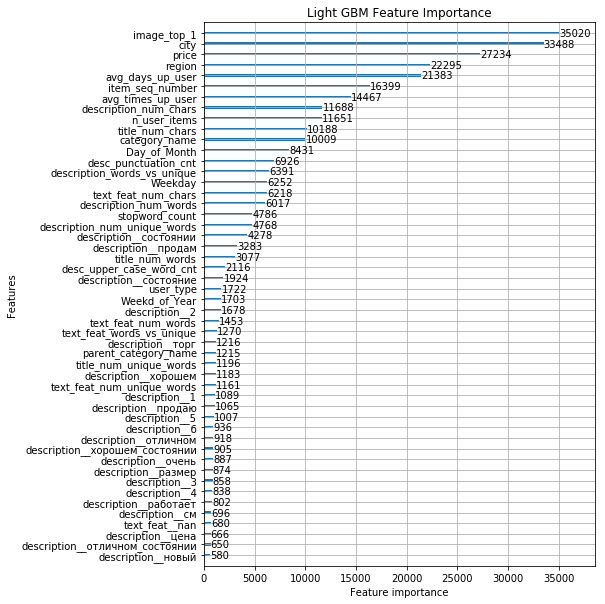

In [31]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.show()

In [33]:
print("Model Evaluation Stage")
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))

lgpred = lgb_clf.predict(testing)
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=test_item)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("lgsub.csv",index=True,header=True)

Model Evaluation Stage
RMSE: 0.21890405476038857


D:\Anaconda\lib\site-packages\lightgbm\basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [34]:
print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

Model Runtime: 174.01 Minutes
Notebook Runtime: 183.35 Minutes
